In [49]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## roi detection

In [0]:
import sys
import cv2
from google.colab.patches import cv2_imshow
import time
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from keras.preprocessing import image

def show_roi_proposed(img, rects):
  print('Total Number of Region Proposals: {}'.format(len(rects)))
  numShowRects = 100
  imOut = img.copy()
  for i, rect in enumerate(rects):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
  cv2_imshow(imOut)


def get_rects(img, strategy=0):
  """three strategies to choose:
  0.SelectiveSearchQuality: produce more rects(sometimes too much)
  1.SelectiveSearchFast: faster method, less rects
  2.SingleStrategy: Fastest, and has least number of rects(also good quality when we have less noise)
  """
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(img)

  if strategy==0:
    ss.switchToSelectiveSearchQuality()
  elif strategy==1:
    ss.switchToSelectiveSearchFast()
  else:
    ss.switchToSingleStrategy()

  rects = ss.process()
  return rects

def remove_useless_rects_efficient(rects): 
  rect_f = rects.copy()
  time_start = time.time()
  #get rid of rects too thin
  rects_delete_index = []
  for i in range(rect_f.shape[0]):
    if rect_f[i,2]*1.0/rect_f[i,3] > 5 or rect_f[i,2]*1.0/rect_f[i,3] < 0.2:
      rects_delete_index.append(i)
  rect_f = np.delete(rect_f,rects_delete_index,axis=0)

  #set dimension 3,4 as coordinate of 2nd point in diagonal to facilite the calculate of distance
  rect_f[:,2:] = rect_f[:,2:] + rect_f[:,:2]
  #get rid of rects too close and similar
  rects_delete_index = set()
  distance = cdist(rect_f[:,:2], rect_f[:,:2])
  distance_diagonal = np.sum(np.abs(rect_f[:,:2]-rect_f[:,2:]),axis=1)
  distance_2 = cdist(rect_f[:,2:], rect_f[:,2:])
  for i in range(distance.shape[0]):
    if i in rects_delete_index:
        continue
    for j in range(i+1, distance.shape[0]):
      if j in rects_delete_index:
        continue
      #if the rects are too close and similar
      if distance[i,j] < distance_diagonal[i]*0.1 and distance_2[i,j]<distance_diagonal[i]*0.3:
        rect_f[j] = np.array([min(rect_f[i,0],rect_f[j,0]), min(rect_f[i,1],rect_f[j,1]),max(rect_f[i,2],rect_f[j,2]),max(rect_f[i,3],rect_f[j,3])]).flatten()
        rects_delete_index.add(i)
        distance_diagonal[j] = np.sum(np.abs(rect_f[j,:2]-rect_f[j,2:]))
        distance[j,:]= cdist(rect_f[j,:2][np.newaxis,:], rect_f[:,:2])
        distance_2[j,:] = cdist(rect_f[j,2:][np.newaxis,:], rect_f[:,2:])
  rect_f = np.delete(rect_f,list(rects_delete_index),axis=0)
  time_end = time.time()
  print('propcess finished, using {0:.2f}s'.format(time_end-time_start))
  rect_f[:,2:] = rect_f[:,2:] - rect_f[:,:2]
  return rect_f
  
def return_object_image(img):
  """input: array of image
  output: images which may contain objects
  """
  newHeight = 200
  # resize image
  newWidth = int(img.shape[1]*newHeight/img.shape[0])
  img = cv2.resize(img, (newWidth, newHeight))   
  # get rects
  rects = get_rects(img, strategy=2)
  rects = remove_useless_rects_efficient(rects)
  show_roi_proposed(img, rects)
  potential_obj = []
  for i in range(len(rects)):
    img_o = img[rects[i,1]:rects[i,1]+rects[i,3],rects[i,0]:rects[i,0]+rects[i,2]].copy()
    potential_obj.append(img_o)
  return potential_obj

## get dataset and trained model

In [0]:
dir_path = 'drive/My Drive/Fruits/'
data_path = dir_path + 'fruits-360_dataset/fruits-360/'

images = np.load(data_path+'images2.npy')
test_images = np.load(data_path+'test_images2.npy')
targets = np.load(data_path+'targets2.npy')
test_targets = np.load(data_path+'test_targets2.npy')

target_name = ['Apple Red 1', 'Apricot','Avocado', 'Banana','Cherry 1', 'Clementine','Cocos', 'Grape Blue','Lemon', 'Mango']


def group_data(imgs, target):
  grouped_data = {}
  for i in range(10):
    grouped_data[i] = imgs[np.argwhere(target==i)[:,0]]
  return grouped_data
  
grouped_data = group_data(images, targets)
test_grouped_data = group_data(test_images, test_targets)

In [0]:
from keras.models import load_model
from keras import backend as K

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred<0.5, y_true.dtype)))

def contrastive_loss(y_true, y_pred):
  '''Contrastive loss from Hadsell-et-al.'06
  http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
  '''
  margin = 5
  square_pred = K.square(y_pred)
  margin_square = K.square(K.maximum(margin - y_pred, 0))
  return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

model_path = dir_path+'fruits2.h5'
model = load_model(model_path, custom_objects={'contrastive_loss': contrastive_loss, "accuracy" : accuracy})

In [0]:
def get_prediction(img, grouped_data, model):
  ps = []
  for i in range(10):
    ps.append(model.predict([img[np.newaxis,:],grouped_data[i][0][np.newaxis,:]]))
  return ps

## get roi of an image

propcess finished, using 0.01s
Total Number of Region Proposals: 24


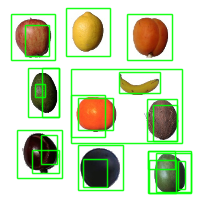

In [4]:
image_path = 'all_fruits.jpg'
img = cv2.imread(image_path)
objs = return_object_image(img)

## prediction for every object detected

0.017820874 9 Mango


0.0006959867 9 Mango


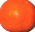

0.008544587 5 Clementine


0.04569897 3 Banana


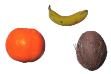

1.5259162 3 Banana


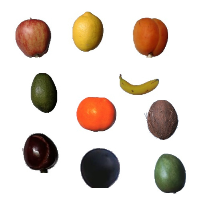

0.3918367 5 Clementine


0.00031622776 7 Grape Blue


0.001008234 7 Grape Blue


0.0025183815 9 Mango


0.0007314377 7 Grape Blue


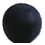

0.000377965 7 Grape Blue


0.0047042263 8 Lemon


0.00031622776 7 Grape Blue


0.001566482 7 Grape Blue


0.009759594 9 Mango


0.0005668301 4 Cherry 1


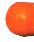

0.028976616 5 Clementine


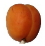

0.002782326 1 Apricot


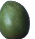

0.00212584 9 Mango


0.0692143 9 Mango


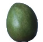

0.0003495985 9 Mango


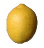

0.028725384 1 Apricot


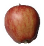

0.033371754 5 Clementine


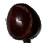

0.0023491138 4 Cherry 1


In [43]:
for obj in objs:
  cv2_imshow(obj)
  img = cv2.resize(obj,(32,32))
  # opencv stores images with BGR, while matplotlib stores with RGB
  b,g,r = cv2.split(img)       # get b,g,r
  img = cv2.merge([r,g,b])     # switch it to rgb
  img = img/255.
  ps = get_prediction(img, grouped_data, model)
  prob = np.min(ps)
  index = np.argmin(ps)
  print(prob, index, target_name[index])

In [36]:
image_path = 'banana.jpeg'
img = image.load_img(image_path, target_size=(32,32,3))
img = np.array(img)/255.
ps = get_prediction(img, grouped_data, model)
prob = np.min(ps)
index = np.argmin(ps)
print(prob, index, target_name[index])

0.066074274 3 Banana


In [35]:
image_path = 'apple.jpg'
img = image.load_img(image_path, target_size=(32,32,3))
img = np.array(img)/255.
ps = get_prediction(img, grouped_data, model)
prob = np.min(ps)
index = np.argmin(ps)
print(prob, index, target_name[index])

0.32388407 5 Clementine


In [37]:
image_path = 'clementine2.jpg'
img = image.load_img(image_path, target_size=(32,32,3))
img = np.array(img)/255.
ps = get_prediction(img, grouped_data, model)
prob = np.min(ps)
index = np.argmin(ps)
print(prob, index, target_name[index]) # 4th possible is clementine

0.17861387 5 Clementine


In [44]:
image_path = 'grape_blue.png'
img = image.load_img(image_path, target_size=(32,32,3))
img = np.array(img)/255.
ps = get_prediction(img, grouped_data, model)
prob = np.min(ps)
index = np.argmin(ps)
print(prob, index, target_name[index])

0.00031622776 7 Grape Blue


In [39]:
image_path = 'lemon.jpg'
img = image.load_img(image_path, target_size=(32,32,3))
img = np.array(img)/255.
ps = get_prediction(img, grouped_data, model)
prob = np.min(ps)
index = np.argmin(ps)
print(prob, index, target_name[index])

0.00084572873 8 Lemon
